In [1]:
from requests import get, post
# from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import spice

[Aave Ethereum - Latest Positions WBTC Focused](https://dune.com/queries/4064703) | [4064703]

In [2]:
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase

# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='../.env')

dune = DuneClient(
    api_key=os.getenv('DUNE_API_KEY2'),
    base_url="https://api.dune.com",
    request_timeout=5000 # request will time out after 300 seconds
)


In [3]:
# Query the latest result into a dataframe
aave_eth_positions = dune.get_latest_result_dataframe(4064703)


In [4]:
def process_positions(threshold=0.78, new_threshold=0.75):
    
    aave_eth_positions_filter0 = aave_eth_positions.copy()
    
    aave_eth_positions_filter0 = aave_eth_positions_filter0[(aave_eth_positions_filter0['LTV'] < threshold) & (aave_eth_positions_filter0['LTV'] > new_threshold)]
    
    delta_collateral = aave_eth_positions_filter0['collateral'].sum()
    delta_debt = aave_eth_positions_filter0['debt'].sum()
    
    print(f'Collateral Affected: {delta_collateral}')
    print(f'Debt Affected: {delta_debt}')
    # Sort the dataframe by LTV 
    aave_eth_positions_sorted = aave_eth_positions.sort_values(by='LTV', ascending=False)
    aave_eth_positions_sorted['key'] = aave_eth_positions_sorted['LTV'] - threshold

    # Split the dataframe based on LTV values
    positive_df = aave_eth_positions_sorted[aave_eth_positions_sorted['key'] >= 0]
    negative_df = aave_eth_positions_sorted[aave_eth_positions_sorted['key'] < 0]

    # Sort positive dataframe in ascending order of LTV
    positive_df = positive_df.sort_values('key', ascending=True)

    # Create aggregate columns for positive dataframe
    positive_df['agg_collateral'] = positive_df['collateral'].cumsum()
    positive_df['agg_debt'] = positive_df['debt'].cumsum()

    # Sort negative dataframe in descending order of LTV (to maintain ascending absolute values)
    negative_df = negative_df.sort_values('key', ascending=False)

    # Create aggregate columns for negative dataframe
    negative_df['agg_collateral'] = negative_df['collateral'].cumsum()
    negative_df['agg_debt'] = negative_df['debt'].cumsum()

    # Concatenate the dataframes
    result_df = pd.concat([negative_df, positive_df], ignore_index=True)
    

    result_df = result_df[(result_df['LTV'] < threshold + 0.3) & (result_df['LTV'] > new_threshold - 0.3)]
    result_df = result_df.sort_values('LTV', ascending=True)

    # Plot the collateral and debt for each key
    plt.figure(figsize=(19, 6))
    # plt.plot(result_df['LTV'], result_df['agg_collateral'], label='Agg Collateral')
    plt.plot(result_df['LTV'], result_df['agg_debt'], label='Agg Debt')
    plt.xlabel('LTV')
    plt.ylabel('Cumulative Value')
    plt.title('Cumulative Collateral and Debt by LTV')
    plt.yscale('log')
    plt.grid(True)
    
    # Add vertical lines for threshold and new_threshold
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.axvline(x=new_threshold, color='g', linestyle='--', label=f'New Threshold ({new_threshold})')
    
    plt.legend()
    plt.show()

    return result_df

Collateral Affected: 157019.81087747242
Debt Affected: 120235.86711838153


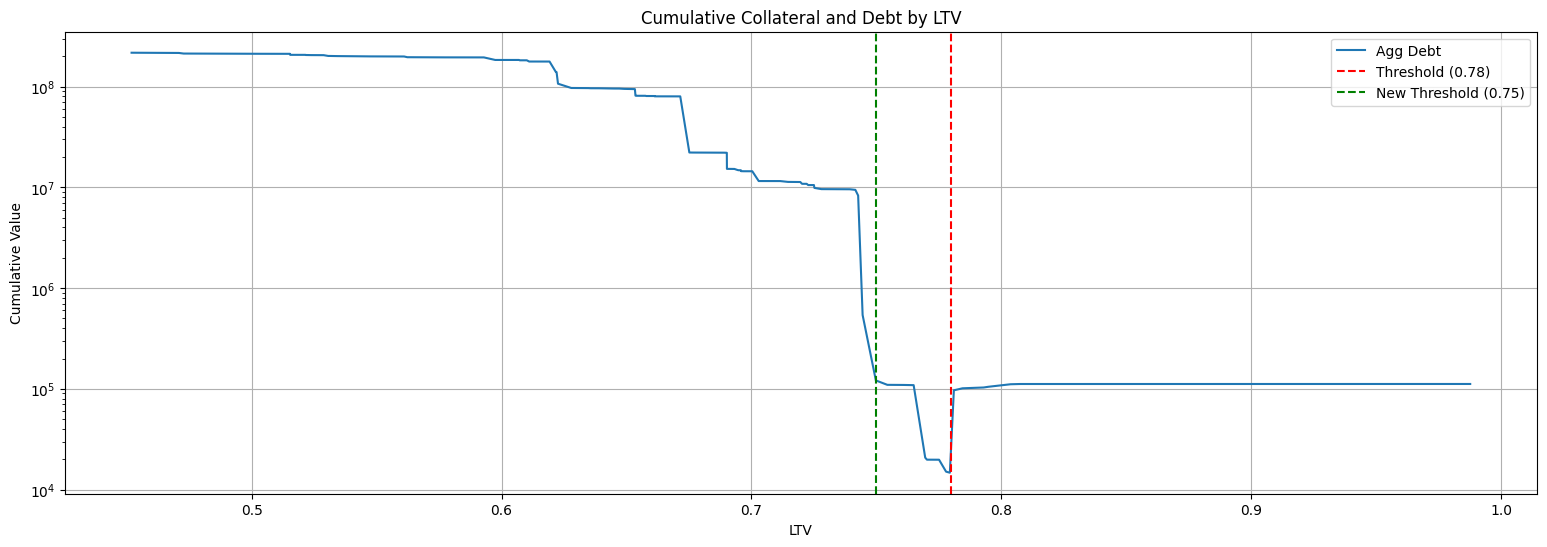

In [5]:
output_df = process_positions(threshold=0.78, new_threshold=0.75) 